In [60]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [61]:
# import tensorflow as tf
# import os

# # Define target image size
# IMG_HEIGHT = 224
# IMG_WIDTH = 224

# # Function to load and preprocess images
# def load_and_preprocess_image(path):
#     image = tf.io.read_file(path)
#     image = tf.image.decode_jpeg(image, channels=3)  # Adjust decode function if using other formats
#     image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
#     image /= 255.0  # Normalize to [0,1] if needed
#     return image

# # Function to get image file paths and labels from a directory structure
# def get_image_paths_and_labels(root_dir):
#     image_paths = []
#     labels = []
#     class_names = sorted(os.listdir(root_dir))
#     class_indices = {name: index for index, name in enumerate(class_names)}

#     for class_name in class_names:
#         class_dir = os.path.join(root_dir, class_name)
#         if os.path.isdir(class_dir):
#             for fname in os.listdir(class_dir):
#                 if fname.endswith('.jpg'):  # Adjust based on format
#                     image_paths.append(os.path.join(class_dir, fname))
#                     labels.append(class_indices[class_name])

#     return image_paths, labels, class_names

# # Directory containing labeled image folders
# root_dir = 'path_to_image_data_folder'  # Replace with your image data folder
# image_paths, labels, class_names = get_image_paths_and_labels(root_dir)

# # Function to load and preprocess images along with their labels
# def load_and_preprocess_from_path_label(path, label):
#     return load_and_preprocess_image(path), label

# # Create a TensorFlow dataset
# dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
# dataset = dataset.map(load_and_preprocess_from_path_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# # Shuffle, batch, and prefetch the dataset
# BATCH_SIZE = 32
# dataset = dataset.shuffle(buffer_size=len(image_paths))
# dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# # Example usage: iterate through the dataset
# for batch_images, batch_labels in dataset:
#     # Process your batch of resized images and labels
#     pass


In [62]:
IMG_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 32

In [63]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Indian_Food_Images",
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
)

Found 400 files belonging to 8 classes.


In [64]:
class_names = dataset.class_names
class_names

['adhirasam',
 'bhatura',
 'butter_chicken',
 'chana_masala',
 'chapati',
 'chicken_tikka',
 'gulab_jamun',
 'jalebi']

In [65]:
36*32

1152

In [66]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch)
    print(label_batch)

tf.Tensor(
[[[[245.        249.        250.       ]
   [244.18164   248.18164   249.18164  ]
   [242.60547   246.60547   247.60547  ]
   ...
   [254.        255.        250.       ]
   [254.        255.        250.       ]
   [254.        255.        250.       ]]

  [[245.        249.        250.       ]
   [244.18164   248.18164   249.18164  ]
   [242.60547   246.60547   247.60547  ]
   ...
   [254.        255.        250.       ]
   [254.        255.        250.       ]
   [254.        255.        250.       ]]

  [[245.        249.        251.39453  ]
   [244.18164   248.18164   250.57617  ]
   [242.60547   246.60547   248.02765  ]
   ...
   [254.        255.        250.       ]
   [254.        255.        250.       ]
   [254.        255.        250.       ]]

  ...

  [[240.60547   246.        246.30273  ]
   [241.17609   246.24774   248.75781  ]
   [237.8164    242.8164    247.9082   ]
   ...
   [245.60547   249.60547   248.60547  ]
   [246.0404    250.22205   248.67712  ]
   [2

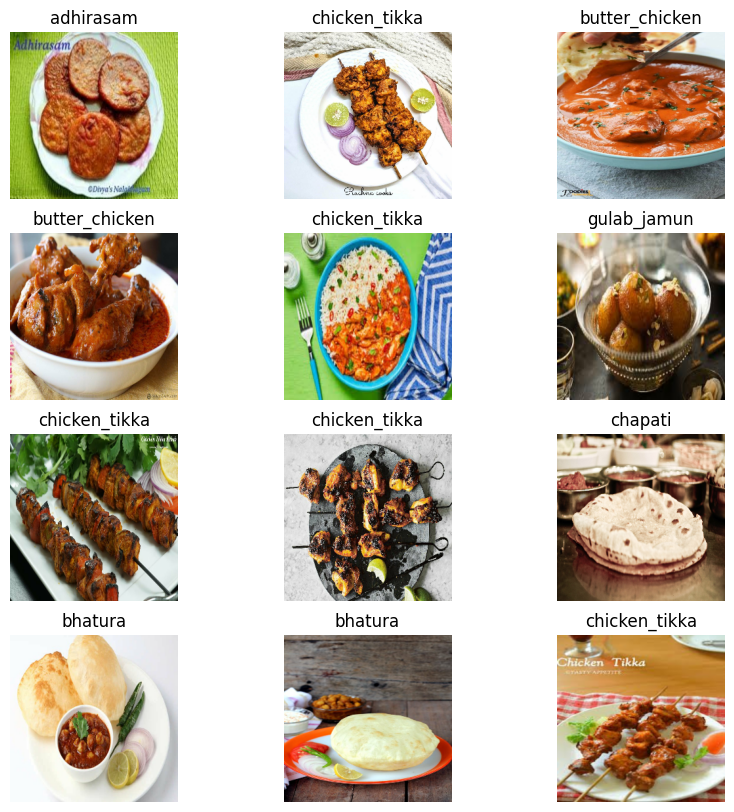

In [67]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [68]:
len(class_names)

8

In [69]:
len(dataset)

13

80% ==> training

20% ==> 10% validation, 10% test

In [70]:
# train_size = 0.8
# len(dataset)*train_size

In [71]:
# train_ds = dataset.take(28)
# len(train_ds)

In [72]:
# rem_ds = dataset.skip(28)
# len(rem_ds)

In [73]:
# test_ds = rem_ds.take(4)
# val_ds = rem_ds.skip(4)
# print('train size',len(train_ds))
# print('test size',len(test_ds))
# print('val size',len(val_ds))

In [74]:
def get_dataset_partition_tf(ds, train_split = 0.8, val_split=0.1, shuffle = True, shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, test_ds, val_ds

In [75]:
train_ds, test_ds, val_ds = get_dataset_partition_tf(dataset)
print('train size',len(train_ds))
print('test size',len(test_ds))
print('val size',len(val_ds))

train size 10
test size 2
val size 1


In [76]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [77]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [78]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
])

In [85]:
input_shape = (IMG_SIZE, IMG_SIZE,3)
n_classes = 8

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),  # Define the input layer with the correct shape
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(n_classes, activation='softmax'),
])


model.build(input_shape = input_shape)

In [86]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   multiple                  0         
                                                                 
 sequential_7 (Sequential)   (None, None, None, 3)     0         
                                                                 
 conv2d_49 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_25 (Bat  (None, 254, 254, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 125, 125, 64)    

In [87]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)

In [88]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [89]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50


10/10 [==============================] - 25s 2s/step - loss: 2.1153 - accuracy: 0.2796 - val_loss: 2.0842 - val_accuracy: 0.1875
Epoch 2/50
10/10 [==============================] - 20s 2s/step - loss: 1.6140 - accuracy: 0.4046 - val_loss: 2.1988 - val_accuracy: 0.1250
Epoch 3/50
10/10 [==============================] - 21s 2s/step - loss: 1.4421 - accuracy: 0.4671 - val_loss: 2.4517 - val_accuracy: 0.1250
Epoch 4/50
10/10 [==============================] - 21s 2s/step - loss: 1.2911 - accuracy: 0.5066 - val_loss: 2.7893 - val_accuracy: 0.1875
Epoch 5/50
10/10 [==============================] - 18s 2s/step - loss: 1.0867 - accuracy: 0.5855 - val_loss: 3.3315 - val_accuracy: 0.1250
Epoch 6/50
10/10 [==============================] - 18s 2s/step - loss: 1.1279 - accuracy: 0.5625 - val_loss: 3.5778 - val_accuracy: 0.1250
Epoch 7/50
10/10 [==============================] - 19s 2s/step - loss: 1.0549 - accuracy: 0.6053 - val_loss: 3.8402 - val_accuracy: 0.1250
Epoch 8/50
10/10 [=============

In [90]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 0s 36ms/step - loss: 1.1899 - accuracy: 0.6562


In [91]:
history

In [92]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 10}

In [93]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [94]:
print(history.history['accuracy'])
len(history.history['accuracy'])

[0.27960526943206787, 0.40460526943206787, 0.46710526943206787, 0.5065789222717285, 0.5855262875556946, 0.5625, 0.6052631735801697, 0.625, 0.6677631735801697, 0.6315789222717285, 0.6578947305679321, 0.7269737124443054, 0.7335526347160339, 0.7203947305679321, 0.7072368264198303, 0.7236841917037964, 0.7697368264198303, 0.7467105388641357, 0.7203947305679321, 0.7532894611358643, 0.7664473652839661, 0.7401315569877625, 0.7861841917037964, 0.7927631735801697, 0.8256579041481018, 0.8059210777282715, 0.8651315569877625, 0.8190789222717285, 0.8453947305679321, 0.8421052694320679, 0.8651315569877625, 0.8651315569877625, 0.8618420958518982, 0.8585526347160339, 0.8322368264198303, 0.8618420958518982, 0.8092105388641357, 0.8190789222717285, 0.8585526347160339, 0.8453947305679321, 0.8453947305679321, 0.8782894611358643, 0.8552631735801697, 0.8782894611358643, 0.9144737124443054, 0.9111841917037964, 0.9506579041481018, 0.8980262875556946, 0.9144737124443054, 0.9539473652839661]


50

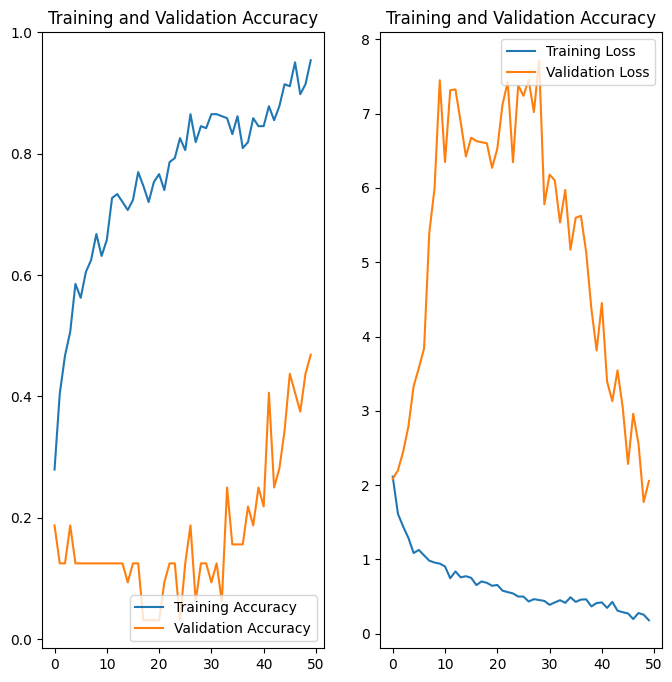

In [95]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), history.history['accuracy'], label="Training Accuracy")
plt.plot(range(50), history.history['val_accuracy'], label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), history.history['loss'], label="Training Loss")
plt.plot(range(50), history.history['val_loss'], label="Validation Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()

first image to predict
first image's actual label: chapati
1/1 [==============================] - 0s 96ms/step
Predicted Label: chapati


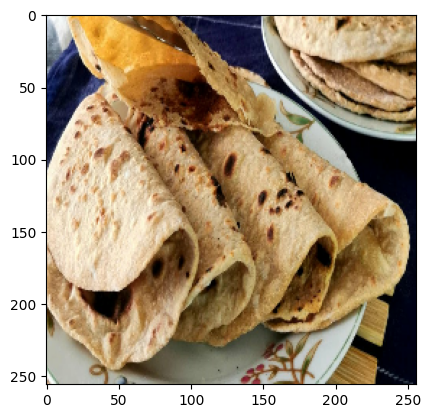

In [96]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()

    print('first image to predict')
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [97]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 14ms/step


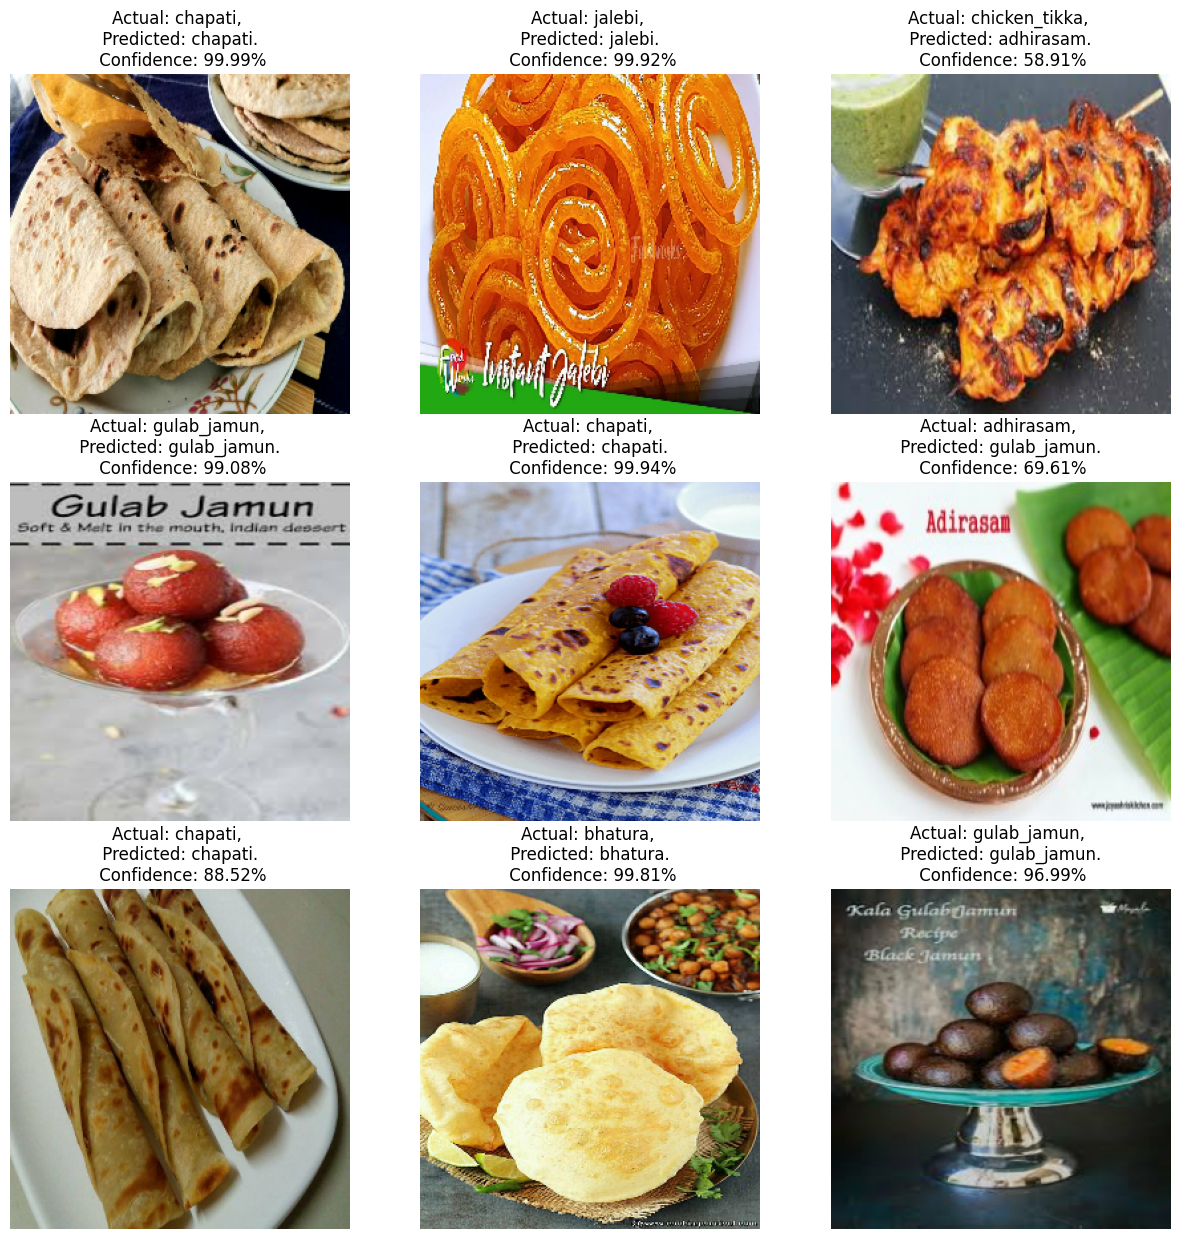

In [100]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(3):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        plt.axis("off")

In [103]:
import os
model_version = max([int(i) for i in os.listdir("models") + [0]]) + 1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets
